# Build in collaboration with Misha Laskin, Chris Heinrich, and Evert P.L. van Nieuwenburg

In [234]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
print("PyTorch Version: ",torch.__version__)
import sys
sys.path.append("/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet")
from utils import data as roof
import importlib
import copy
#print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1


In [235]:
#Helper function:

def make_data_array(data): # data is a list of tuples
    out = [] # list of dictionaries
    for l in range(len(data)//7):   # 7 images per roof
        hold = {'img':[],'year':[],'meta':[]} # dictionary for each roof
        for i in range(7):  # 7 images per roof
            img, year, meta = data[l*7+i]   # data is a list of tuples
            hold['img'].append(img) # list of tensors
            hold['year'].append(year) # list of ints
            hold['meta'].append(meta) # list of dictionaries
        out.append(hold) # list of dictionaries 
    return out # list of dictionaries
        

In [236]:
# we dont need
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNet"

In [237]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet" 

# Size of latent space
latent_space = 128

# Batch size for training (change depending on how much memory you have)
batch_size = 3

# Number of epochs to train for
num_epochs = 25

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

IMG_SHAPE = 224

# Follwoing the PyTorch guide to finetuning Torchvision Models

In [238]:
def run_model(model, dataloaders):     
    score_hold = {'anchor':[],'pos':[],'neg':[]} # dictionary of lists

    model.eval()   # Set model to evaluate mode

    for x, y, meta in dataloaders: # x is a list of 3 tensors, y is a list of 3 ints, meta is a list of 3 dictionaries
        anchor = x[0].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device) # tensor of shape (1,3,224,224)
        pos = x[1].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)    # tensor of shape (1,3,224,224)
        neg = x[2].view(-1,3,IMG_SHAPE,IMG_SHAPE).to(device)    # tensor of shape (1,3,224,224)

      
        with torch.set_grad_enabled(False): # no need to calculate gradients here
            anchor_output = model(anchor)   # tensor of shape (1,128)
            pos_output = model(pos)        # tensor of shape (1,128)
            neg_output = model(neg)     # tensor of shape (1,128)
 
            score_hold['anchor'].append(anchor_output.detach().cpu().numpy())   # list of tensors of shape (1,128)
            score_hold['pos'].append(pos_output.detach().cpu().numpy())     # list of tensors of shape (1,128)
            score_hold['neg'].append(neg_output.detach().cpu().numpy())         # list of tensors of shape (1,128)


    return score_hold # dictionary of lists of tensors of shape (1,128)

In [239]:
#This helper function sets the .requires_grad attribute of the parameters in the model to False when we are feature extracting. 
#By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. 
#However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. 

def set_parameter_requires_grad(model, feature_extracting): # model is a nn.Module, feature_extracting is a boolean
    if feature_extracting: 
        for param in model.parameters(): # model.parameters() is a generator of tensors
            param.requires_grad = False 

In [90]:
# Initialize a model with pretrained weights of a chosen architecture (resnet18, alexnet, vgg, squeezenet, densenet, inception)

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained) # model_ft is a nn.Module
    set_parameter_requires_grad(model_ft, feature_extract) # model_ft is a nn.Module, feature_extract is a boolean
    num_ftrs = model_ft.fc.in_features # num_ftrs is an int which is the number of input features for the last layer
    model_ft.fc = nn.Sequential(nn.Dropout(0.25),nn.Linear(num_ftrs, num_classes)) #Trying with dropout 
    input_size = IMG_SHAPE 

    return model_ft, input_size 


In [91]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [194]:
from captum.attr import LayerGradCam

model = models.resnet18(pretrained=True)
target_layer = model.layer4[1].conv2
grad_cam = LayerGradCam(model, target_layer)

/Users/Lisa/anaconda3/envs/roofxai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Lisa/anaconda3/envs/roofxai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: LayerGradCam.__init__() got an unexpected keyword argument 'relu_attributions'

In [195]:
#NAN Fixer
def batch_helper(x): # x is a list of tensors of shape (1,128)
    b_size = int(len(x))    # b_size is an int
    anchor = x[list(range(0,b_size,3))]     # anchor is a list of tensors of shape (1,128)
    pos = x[list(range(1,b_size,3))]    # pos is a list of tensors of shape (1,128)
    neg = x[list(range(2,b_size,3))]    # neg is a list of tensors of shape (1,128)
    return anchor, pos, neg     # anchor, pos, neg are lists of tensors of shape (1,128)

def train_model_acc_noNAN(model, dataloaders_train, dataloaders_test, optimizer, margin = 0.0,  num_epochs=25, best_acc = 0.0):  
    since = time.time()     

    val_acc_history = [] # list of floats
    training_loss_history = []  # list of floats
    
    epoch_score = []    # list of dictionaries of lists of tensors of shape (1,128)
    

    best_model_wts = copy.deepcopy(model.state_dict())  # best_model_wts is a dictionary of tensors
    best_acc = best_acc # best_acc is a float

    for epoch in range(num_epochs): # num_epochs is an int
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))  
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:  # phase is a string
            if phase == 'train':
                model.train()  # Set model to training mode         
                dataloaders = dataloaders_train 
            else:
                model.eval()   # Set model to evaluate mode
                dataloaders = dataloaders_test     

            running_loss = 0.0 # running_loss is a float
            running_corrects = 0.0  # running_corrects is a float
            batches = 0.0   # batches is a float
            score_hold = {'anchor':[],'pos':[],'neg':[]} # score_hold is a dictionary of lists of tensors of shape (1,128)

            # Iterate over data.
            for x, y, meta in dataloaders: # x is a list of tensors of shape (1,3,224,224), y is a list of tensors of shape (1), meta is a list of strings
                x = batch_helper(x)     # x is a tuple of lists of tensors of shape (1,128)
                anchor = x[0].to(device)   # tensor of shape (1,128)
                pos = x[1].to(device)  # tensor of shape (1,128)
                neg = x[2].to(device)       # tensor of shape (1,128)

                # zero the parameter gradients
                optimizer.zero_grad()   

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    anchor_output = model(anchor) 
                    pos_output = model(pos)
                    neg_output = model(neg)
                    
                    #trying to fix NAN, bootleg fix that does the job
                    anchor_output[anchor_output!=anchor_output]=0 
                    pos_output[pos_output!=pos_output] = 0 
                    neg_output[neg_output!=neg_output] = 0
                    
                    
                    pos_term = torch.sqrt((anchor_output - pos_output).pow(2)).sum(1) # sum across the 128 dimensions
                    neg_term = torch.sqrt((anchor_output - neg_output).pow(2)).sum(1) # sum across the 128 dimensions

                    # loss = torch.mean(F.relu(pos_term - neg_term + margin))  # we maximize the margin between the positive and negative terms
                   
                    # Compute the XAI regularization term
                    # anchor_output_batch = anchor_output.unsqueeze(0).repeat(1, 3, 1, 1)
                    # anchor_attributions = grad_cam.attribute(anchor_output_batch, target=17, relu_attributions = True)
                    # pos_output_batch = pos_output.unsqueeze(0).repeat(1, 3, 1, 1)
                    # pos_attributions = grad_cam.attribute(pos_output_batch, target =17, relu_attributions = True)
                    # neg_output_batch = neg_output.unsqueeze(0).repeat(1, 3, 1, 1)
                    # neg_attributions = grad_cam.attribute(neg_output_batch, target =17, relu_attributions = True)
                    
                    # xai_regularization = F.relu(anchor_attributions - pos_attributions) + F.relu(anchor_attributions - neg_attributions)
                    # xai_regularization = torch.mean(xai_regularization)
                    # lambda_xai = 0.1
                    
                    loss = torch.mean(F.relu(pos_term - neg_term + margin)) # + lambda_xai * xai_regularization

                    # backward + optimize only if in training phase because we want to update the weights
                    if phase == 'train': 
                        optimizer.zero_grad() 
                        #(loss + xai_regularization).backward()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() 
                acc = torch.mean(torch.stack([pos_term<neg_term]).double())
                running_corrects += acc
                batches += 1.0


            epoch_loss = running_loss / batches
            epoch_acc = running_corrects.double() / batches
            
            epoch_score.append(score_hold)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) 
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            else:
                training_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, training_loss_history, epoch_score # 

In [196]:
# Initialize the model for this run
model_ft, input_size = initialize_model(latent_space, feature_extract, use_pretrained=True)

# Print the model we just instantiated
#print(model_ft)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

Params to learn:
	 fc.1.weight
	 fc.1.bias


# Run the model

In [197]:
importlib.reload(roof) # reload the roof module

<module 'utils.data' from '/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/roofnet/utils/data.py'>

In [198]:
data_dir = "/Users/Lisa/Desktop/Master Thesis/RoofNetXAI/preprocessed_data"
data_file_path = data_dir + "/train_64_noreroofs.npy" # train 
data = roof.ImageDataset(data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToPILImage(mode='RGB'),
                                transforms.ColorJitter(0.5,0.5,0.5,0),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ]))
                    # jitter=False)

val_data_file_path = data_dir + "/val_64_noreroofs.npy" # val
val_data = roof.ImageDataset(val_data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Try with normalization values, if nothing works remove
                            ]))

Loading data
Done loading data
Length 1050
Num Roofs 150
Loading data
Done loading data
Length 175
Num Roofs 25


In [199]:
BATCH_SIZE = 16
NUM_BATCHES = 200

VAL_BATCHES = 100

sampler = roof.TripletBuildingSampler(data,batch_size=BATCH_SIZE*NUM_BATCHES)
loader = torch.utils.data.DataLoader(data, sampler=sampler,batch_size=BATCH_SIZE*3)

val_sampler = roof.TripletBuildingSampler(val_data,batch_size=BATCH_SIZE*VAL_BATCHES)
val_loader = torch.utils.data.DataLoader(val_data, sampler=val_sampler,batch_size=BATCH_SIZE*3)

# Start with no margin and increase once network can match positive case

In [231]:
model_ft, hist, train_loss, score = train_model_acc_noNAN(model_ft, loader, val_loader, optimizer_ft, num_epochs=15, margin=0.0, best_acc = 0.831)
# time: 30min Normal
# time: 34min with XAI regularization relu = False


Epoch 0/14
----------
train Loss: 7.5142 Acc: 0.5147
val Loss: 8.9963 Acc: 0.5381

Epoch 1/14
----------
train Loss: 6.7471 Acc: 0.5300
val Loss: 8.6251 Acc: 0.5225

Epoch 2/14
----------
train Loss: 6.3444 Acc: 0.5537
val Loss: 9.0649 Acc: 0.5669

Epoch 3/14
----------
train Loss: 6.2480 Acc: 0.5625
val Loss: 8.1866 Acc: 0.5769

Epoch 4/14
----------
train Loss: 6.0916 Acc: 0.5834
val Loss: 8.5448 Acc: 0.5637

Epoch 5/14
----------
train Loss: 5.7617 Acc: 0.5847
val Loss: 8.2334 Acc: 0.5781

Epoch 6/14
----------
train Loss: 5.3740 Acc: 0.6034
val Loss: 8.0596 Acc: 0.5863

Epoch 7/14
----------
train Loss: 5.4938 Acc: 0.5994
val Loss: 7.7175 Acc: 0.6069

Epoch 8/14
----------
train Loss: 5.4358 Acc: 0.6062
val Loss: 7.1203 Acc: 0.5931

Epoch 9/14
----------
train Loss: 5.2443 Acc: 0.6125
val Loss: 8.8401 Acc: 0.5312

Epoch 10/14
----------
train Loss: 5.0637 Acc: 0.6234
val Loss: 8.5250 Acc: 0.5587

Epoch 11/14
----------
train Loss: 5.2746 Acc: 0.6131
val Loss: 8.1526 Acc: 0.5469

Ep

In [200]:
# regularization terms introduce additional penalties that contribute to the overall loss and can increase its value.
# relu is true because it was in the original GradCam paper
model_ft, hist, train_loss, score = train_model_acc_noNAN(model_ft, loader, val_loader, optimizer_ft, num_epochs=10, margin=5.0, best_acc = 0.831)
# time: 30 min with GradCAm regularization relu = True

Epoch 0/9
----------
train Loss: 10.4428 Acc: 0.5141
val Loss: 11.3120 Acc: 0.5637

Epoch 1/9
----------
train Loss: 9.4679 Acc: 0.5397
val Loss: 11.0271 Acc: 0.5556

Epoch 2/9
----------
train Loss: 8.7493 Acc: 0.5653
val Loss: 11.1468 Acc: 0.5725

Epoch 3/9
----------
train Loss: 8.6606 Acc: 0.5778
val Loss: 12.1021 Acc: 0.5619

Epoch 4/9
----------
train Loss: 8.1700 Acc: 0.5916
val Loss: 12.1427 Acc: 0.5556

Epoch 5/9
----------
train Loss: 8.2960 Acc: 0.5941
val Loss: 11.0417 Acc: 0.6025

Epoch 6/9
----------
train Loss: 7.8606 Acc: 0.6091
val Loss: 12.0783 Acc: 0.5537

Epoch 7/9
----------
train Loss: 8.1437 Acc: 0.5984
val Loss: 11.1041 Acc: 0.5406

Epoch 8/9
----------
train Loss: 7.4918 Acc: 0.6294
val Loss: 11.4088 Acc: 0.5763

Epoch 9/9
----------
train Loss: 7.8220 Acc: 0.6241
val Loss: 10.7964 Acc: 0.6269

Training complete in 33m 7s
Best val Acc: 0.831000


In [201]:
torch.save(model_ft.state_dict(),'TripleLoss Experiment 64 Train Val GradCam Relu True')

# Evaluate the latent vectors

In [202]:
def get_metrics(model, data, anchor_index=0): 
    #Returns distance to anchor, magnitude of latent vector, and distance to neighbor
    #Input is normalized PyTorch vector, same parameters as in training

    model.eval()   # Set model to evaluate mode
    
    anchor = data['img'][anchor_index].unsqueeze(0).to(device) # anchor image
    anchor_output = model(anchor) # latent vector
    anchor_value = anchor_output.detach().cpu().numpy() # latent vector value
    anchor_value[anchor_value != anchor_value] = 0 # remove NaN values
    
    compare_to_anchor = [] # distance to anchor
    magnitude = []  # magnitude of latent vector
    compare_to_next = []    # distance to neighbor
    
    
    temp =  model(data['img'][0].unsqueeze(0).to(device)).detach().cpu().numpy() # latent vector of first image
    temp[temp != temp] = 0 # remove NaN values
    
    
    for i in range(len(data['img'])): # for each image in the batch
        compare = data['img'][i].unsqueeze(0).to(device) # compare image
        compare_output = model(compare) # latent vector
        compare_value = compare_output.detach().cpu().numpy() # latent vector value
        compare_value[compare_value!=compare_value] = 0
         
        compare_to_anchor.append(np.sqrt(np.sum(np.square(anchor_value-compare_value))))
        magnitude.append(np.sqrt(np.sum(np.square(compare_value))))
        compare_to_next.append(np.sqrt(np.sum(np.square(temp-compare_value))))
        
        temp = compare_value

    return compare_to_anchor, magnitude, compare_to_next

# Vizualize various comparison techniques on trained data

In [203]:
dataset = np.load(data_file_path,allow_pickle=True)
dataset = dataset.item().get('data')

In [204]:
solo_sampler = roof.TripletBuildingSampler(data,batch_size=1)
solo_loader = torch.utils.data.DataLoader(data, sampler=solo_sampler,batch_size=3)
sorted_data = make_data_array(data)

In [205]:
n += 1

In [206]:
comp_a, mag, comp_n = get_metrics(model_ft,sorted_data[n],anchor_index=0)
print('Compare to anchor: ',comp_a, 'Pred year: ',comp_a.index(max(comp_a))+2012)
print('Magnitude: ',mag,'Pred year: ',mag.index(max(mag))+2012)
print('Compare to next: ', comp_n,'Pred year: ',comp_n.index(max(comp_n))+2012)

Compare to anchor:  [0.0, 9.60477, 10.816388, 11.345177, 11.020886, 9.679801, 9.488305] Pred year:  2015
Magnitude:  [16.458467, 15.230782, 11.212975, 14.530777, 14.354155, 12.881942, 17.561575] Pred year:  2018
Compare to next:  [0.0, 9.60477, 7.579609, 6.420057, 3.888982, 6.6493998, 7.366476] Pred year:  2013


In [207]:
print(sorted_data[n]['meta'][0]['transition_year'])

0


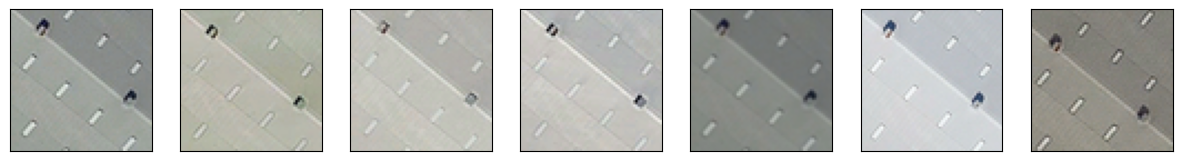

In [208]:
imgs = dataset[sorted_data[n]['meta'][0]['address']]['imgs']
f, axs = plt.subplots(1,7,figsize=(15,5))
for i in range(len(imgs)):
    axs[i].imshow(imgs[i])
    axs[i].axes.get_xaxis().set_visible(False)
    axs[i].axes.get_yaxis().set_visible(False)
plt.show(f)

In [209]:
#Run comparisons over entire data stream, a set with no threshold and dumb maximum check, 
#second set with threshold and moving anchor

def get_accuracy_over_data(model,data,threshold=0.16,abs_mag=False,anchor_index=0):

    simple_pred = []
    simple_pred_acc = []

    time_pred = []
    time_pred_acc = []
    
    pred_year = []
    
    address = []

    for i in data:
        comp_a, mag, comp_n = get_metrics(model,i,anchor_index)
        trans_year = i['meta'][0]['transition_year']
        pred_year.append(trans_year)
        address.append(i['meta'][0]['address'])

        #simple predictors:
        comp_a_pred = comp_a.index(max(comp_a))+2012
        mag_pred = mag.index(max(mag))+2012
        comp_n_pred = comp_n.index(max(comp_n))+2012

        simple_pred.append(np.array([comp_a_pred,mag_pred,comp_n_pred]))
        simple_pred_acc.append(np.array([abs(comp_a_pred-trans_year),abs(mag_pred-trans_year),abs(comp_n_pred-trans_year)]))

        #Predictors sensative to time series data:
        time_pred_hold = []
        time_pred_acc_hold = []

        for j in range(anchor_index+2,len(comp_a)):
            if comp_a[j] > comp_a[anchor_index+1]*(1 + threshold):
                time_pred_hold.append(2012+j)
                time_pred_acc_hold.append(abs(2012+j-trans_year))
                break
            if j == len(comp_a)-1:
                time_pred_hold.append(2012+anchor_index+1)
                time_pred_acc_hold.append(abs(2012+anchor_index+1-trans_year))

        for j in range(0,len(mag)):
            if abs_mag:
                delta_mag = np.abs(mag[j]-mag[anchor_index])
            else:
                delta_mag = mag[j]-mag[anchor_index]
            if delta_mag > mag[anchor_index]*(threshold):
                time_pred_hold.append(2012+j)
                time_pred_acc_hold.append(abs(2012+j-trans_year))
                break
            if j == len(mag)-1:
                time_pred_hold.append(2012)
                time_pred_acc_hold.append(abs(2012-trans_year))

        for j in range(1,len(comp_n)):
            if comp_n[j] > comp_n[anchor_index+1]*(1 + threshold):
                time_pred_hold.append(2012+j)
                time_pred_acc_hold.append(abs(2012+j-trans_year))
                break
            if j == len(comp_n)-1:
                time_pred_hold.append(2012)
                time_pred_acc_hold.append(abs(2012-trans_year))

        time_pred.append(np.array(time_pred_hold))
        time_pred_acc.append(np.array(time_pred_acc_hold))
    
    pred_year = np.array(pred_year)
    
    simple_pred = np.array(simple_pred)
    simple_pred_acc = np.array(simple_pred_acc)

    time_pred = np.array(time_pred)
    time_pred_acc = np.array(time_pred_acc)
    
    address = np.array(address)
    
    return simple_pred, simple_pred_acc, time_pred, time_pred_acc, pred_year, address


# Test various anchors

In [210]:
simple_pred, simple_pred_acc, time_pred, time_pred_acc,pred_year,address = get_accuracy_over_data(model_ft,sorted_data,threshold=0.25)
np.mean(simple_pred,0)

array([2015.83333333, 2015.42      , 2015.38666667])

In [211]:
simple_pred_1, simple_pred_acc_1, time_pred_1, time_pred_acc_1, pred_year,address = get_accuracy_over_data(model_ft,sorted_data,threshold=0.25,anchor_index=1)
np.mean(simple_pred_1,0)

array([2015.61333333, 2015.42      , 2015.38666667])

In [212]:
simple_pred_2, simple_pred_acc_2, time_pred_2, time_pred_acc_2, pred_year,address = get_accuracy_over_data(model_ft,sorted_data,threshold=0.25,anchor_index=2)
np.mean(simple_pred_2,0)

array([2015.        , 2015.42      , 2015.38666667])

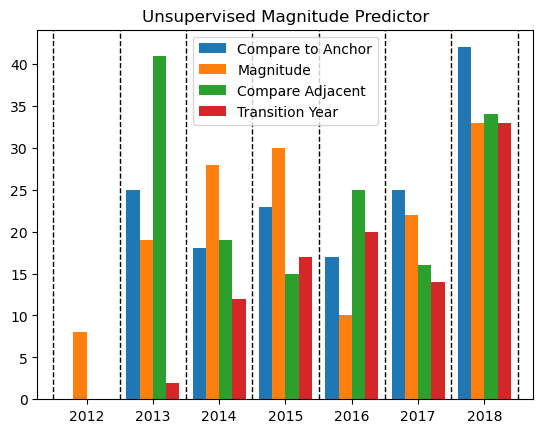

In [213]:
plt.hist(np.hstack((simple_pred,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

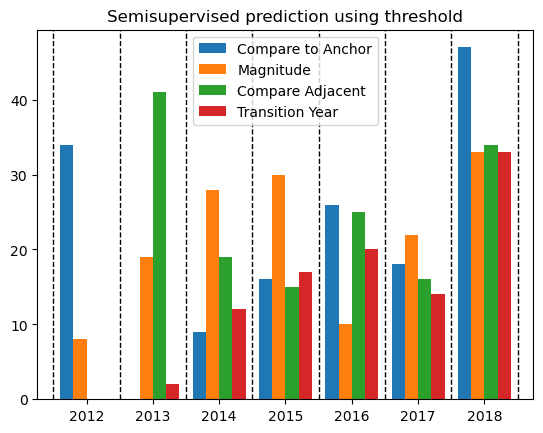

In [214]:
plt.hist(np.hstack((simple_pred_1,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Semisupervised prediction using threshold')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

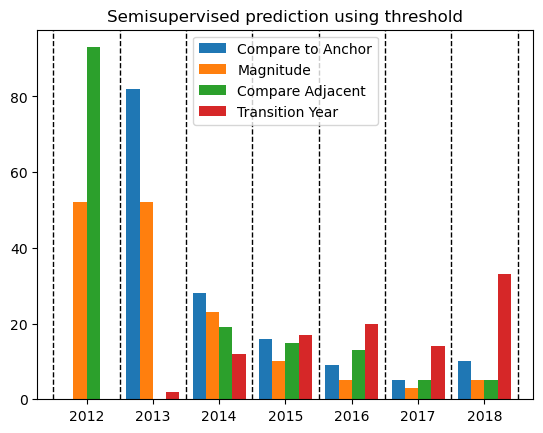

In [215]:
plt.hist(np.hstack((time_pred,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Semisupervised prediction using threshold')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

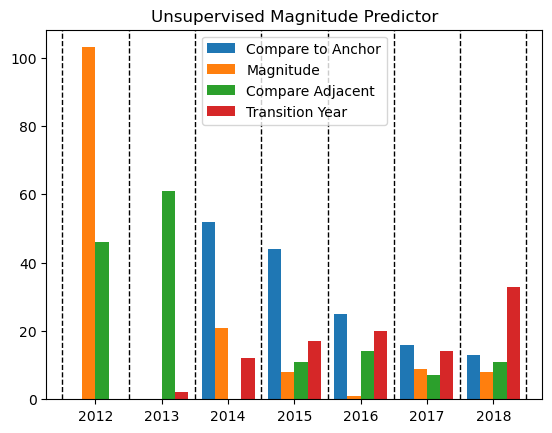

In [216]:
plt.hist(np.hstack((time_pred_1,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

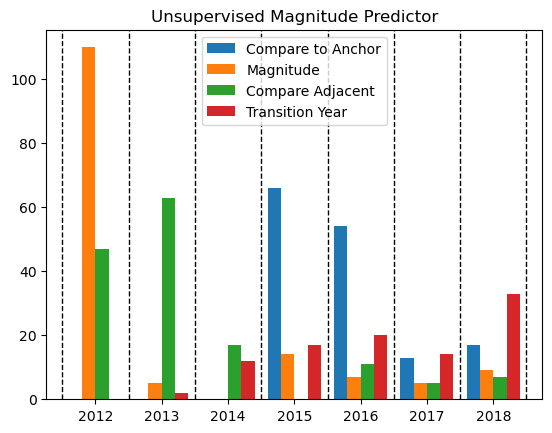

In [217]:
plt.hist(np.hstack((time_pred_2,pred_year.reshape(len(pred_year),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

# Testing accuracy of different anchors and techniques to use on test data

In [218]:
np.mean(time_pred_acc,0)

array([686.63333333, 687.11333333, 686.90666667])

In [219]:
np.mean(time_pred_acc_1,0)

array([686.25333333, 687.11333333, 686.72666667])

In [220]:
np.mean(time_pred_acc_2,0)

array([686.40666667, 687.50666667, 687.01333333])

# Test Data, evaluate with anchor 0 and comparison to anchor

In [221]:
#Normal data set of images and meta data before being passed into PyTorch tensors
val_dir = "/test_64_noreroofs.npy"
valdata = np.load(data_dir + val_dir,allow_pickle=True)
valdata = valdata.item().get('data')

In [222]:
val_data_file_path = data_dir + val_dir
val_data = roof.ImageDataset(val_data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Try with normalization values, if nothing works remove
                            ]))
val_solo_sampler = roof.TripletBuildingSampler(val_data,batch_size=1)
val_solo_loader = torch.utils.data.DataLoader(val_data, sampler=val_solo_sampler,batch_size=3)
sorted_val = make_data_array(val_data)

Loading data
Done loading data
Length 385
Num Roofs 55


In [223]:
simple_pred_v_0, simple_pred_acc_v_0, time_pred_v_0, time_pred_acc_v_0, pred_year_v, address_v = get_accuracy_over_data(model_ft,sorted_val,threshold=0.10,anchor_index=0)
np.mean(time_pred_acc_v_0,0)

array([916.85454545, 917.67272727, 917.2       ])

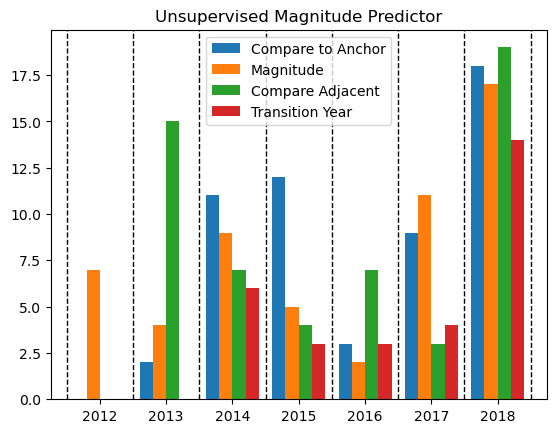

In [224]:
plt.hist(np.hstack((simple_pred_v_0,pred_year_v.reshape(len(pred_year_v),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Unsupervised Magnitude Predictor')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

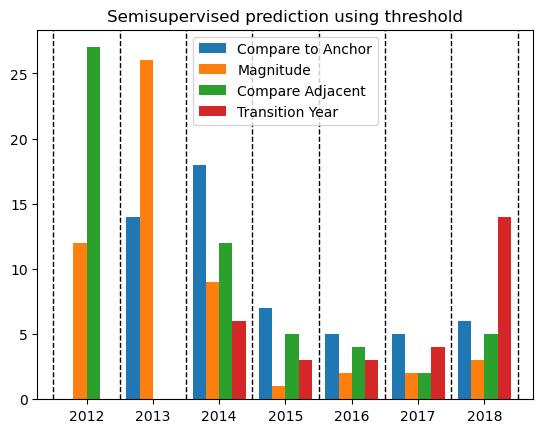

In [225]:
plt.hist(np.hstack((time_pred_v_0,pred_year_v.reshape(len(pred_year_v),1))),bins = np.linspace(2011.5,2018.5,8))
plt.legend(['Compare to Anchor','Magnitude','Compare Adjacent','Transition Year'])
plt.title('Semisupervised prediction using threshold')
for i in np.linspace(2011.5,2018.5,8):
    plt.axvline(i, color = 'k', ls = '--', lw = 1)
plt.show()

In [226]:
out = {'site_address': address_v, 'transition_true': pred_year_v, 'transition_predicted': time_pred_v_0[:,0]}

In [192]:
import pandas as pd

# Output results on test data for paper


In [227]:
pd.DataFrame(out).to_csv('TripletlossGradRelutrue.csv')

TEST PERFORMANCE

In [233]:
import torch
import torchvision.models as models

# Load the trained model
model = models.resnet18(pretrained=False)
 


/Users/Lisa/anaconda3/envs/roofxai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Lisa/anaconda3/envs/roofxai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
test_dataset = 
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)  # Assuming batch size of 1 for evaluation


In [ ]:

# Define the transforms for the test data
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Load the trained model
model = resnet18(pretrained=False)
model.load_state_dict(torch.load('model_checkpoint.pth'))
model.eval()

correct = 0
total = 0

# Iterate over the test data
for images, labels in test_dataloader:
    # Forward pass
    outputs = model(images)
    
    # Compute predictions
    _, predicted = torch.max(outputs.data, 1)
    
    # Count the number of correct predictions
    correct += (predicted == labels).sum().item()
    
    # Update the total number of test samples
    total += labels.size(0)

# Calculate the generalization accuracy
accuracy = 100 * correct / total
print('Generalization Accuracy: {:.2f}%'.format(accuracy))